In [1]:
# Manage imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

import copy

In [2]:
# Set up model
# Model data downloaded from "https://github.com/tamim662/YOLO-Fish"
net = cv2.dnn.readNetFromDarknet('./model/yolo-fish-2.cfg', './model/merge_yolo-fish-2.weights')
model = cv2.dnn_DetectionModel(net)

# Use model to find fish
def detect_fish(img):
    """
    Find fish in img
    :param img: single frame in which to detect fish
    :return: array containing bounding box descriptors
    """
    fish_boxes = []
    # High nms threshold accounts for close proximity of fish in schools
    _, scores, boxes = model.detect(img, nmsThreshold=0.6)
    for score, box in zip(scores, boxes):
        if score >= 0.5:
            fish_boxes.append(box)

    return fish_boxes

In [3]:
# Compare bounding boxes to track fish

# For each bounding box:
# find the centrepoint
# use centrepoint to store hits detected per pixel
# use pixel coordinates to find ids of objects in hit range
# compare feature descriptions (SIFT) to determine best match in range

# Create array to track object locations
def create_object_location_tracker(height, width):
    """
    Create a tracker to store object data at an x, y index related to its last known location
    :param height: number of rows to be included in numpy array
    :param width: number of columns to be included in numpy array
    :return object_tracker: a numpy array shaped according to inputs where each cell is initialised with 0
    """
    object_tracker = np.zeros((height, width))
    return object_tracker

# Use centrepoint to record object location
def calculate_centrepoint(x, y, w, h):
    """
    Calculate centrepoint as reference for object movement
    :param x: x related to top left corner of bounding region
    :param y: y related to top left corner of bounding region
    :param w: width of bounding region
    :param h: height of bounding region
    :return centrepoint: tuple describing centre of bounding region
    """
    centrepoint = (x + w//2, y + h//2)
    return centrepoint

# Convert 2d coordinates to 1d index
def flatten_coordinates(row, col, row_length):
    """
    Take a 2d coordinate and convert to equivalent index in a flattened array
    :param row: first coordinate (row) for numpy index
    :param col: second coordinate (column) for numpy index
    :param row_length: number of elements in each row of the 2d array
    :return flattened_index: Single index value for a flattened array equivalent to the 2d input
    """
    flattened_index = (row * row_length) + col
    return flattened_index

# Populate object information
def populate_object_trackers(hit_tracker, id_tracker, object_tracker, object_info):
    """
    Update object tracking structures with a singular object
    :param hit_detector: 2d Numpy array used to track pixels where an object has been detected
    :param id_tracker: List of lists used to track ids, structure is a flattened version of the hit_detector
    :param object_tracker: Dictionary in which keys are object ids and values are object properties
    :param object_info: Object properties such as centre coordinate and SIFT features
    """
    # Get object coordinates
    (x, y, id, sift_features) = object_info
    column = x
    row = y
    # Update hit detector
    hit_tracker[row, column] += 1
    # Convert coordinate to flat index and update ids associated with pixel
    row_length = np.shape(hit_tracker)[1]
    flat_index = flatten_coordinates(row, column, row_length)
    (id_tracker[flat_index]).append(id) 
    # Update stored information about object
    object_tracker[id] = {
        "x": x,
        "y": y,
        "features": sift_features
    }

# Check if there is an object associated with a particular point
def check_for_existing_object(x, y, range, hit_tracker, id_tracker):
    """
    Check if object is already being tracked
    :param x: x of centrepoint of object of interest
    :param y: y of centrepoint of object of interest
    :param range: radius of search area in object_array
    :param hit_tracker: array containing data about previously detected objects
    :param id_tracker: list of lists tracking ids associated with particular pixels
    :return hit_ids: list of potential match ids, empty if no match (i.e. new object)
    """
    # Limit search area to array boundaries
    object_array_shape = np.shape(hit_tracker)
    num_rows = object_array_shape[0]
    num_cols = object_array_shape[1]
    # Find row boundaries
    top_boundary = max(0, y - range)
    bottom_boundary = min(num_rows, y + range + 1)
    # Find column boundaries
    left_boundary = max(0, x - range)
    right_boundary = min(num_cols, x + range + 1)
    # Collect all items in range
    search_area = hit_tracker[top_boundary : bottom_boundary, left_boundary : right_boundary]
    # Find pixels with associated objects in search area
    positive_hits = np.nonzero(search_area)
    nonzero_row = positive_hits[0]
    nonzero_col = positive_hits[1]
    hit_ids = []
    for row, col in zip(nonzero_row, nonzero_col):
        adjusted_row = row + top_boundary
        adjusted_column = col + left_boundary
        flat_index = flatten_coordinates(adjusted_row, adjusted_column, num_cols)
        # Get ids related to hits
        for id in id_tracker[flat_index]:
            hit_ids.append(id)
    # Get ids and find best match
    return hit_ids

# Find best match from list of ids
def find_best_match(target_features, potential_matches, object_tracker):
    """
    Find best match from potential objects
    :param target_features: SIFT features of object of interest
    :param potential_matches: List of ids of objects to compare against
    :param object_tracker: Dictionary where keys are ids and values include SIFT features
    :return id: Id of best match or -1 if no suitable match
    """
    best_match_score = 0
    best_match_id = -1
    brute_force_matcher = cv2.BFMatcher()
    # brute_force_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    for id in potential_matches:
        possible_match = object_tracker[id]
        features = possible_match["features"]
        matches = brute_force_matcher.match(target_features, features)
        # Calculate score of matches to find best match
        if len(matches) != 0:
            similar_regions = [i for i in matches if i.distance < 50]
            match_score = len(similar_regions) / len(matches)
            if match_score > best_match_score:
                best_match_score = match_score
                best_match_id = id
    # If unable to determine a match with sift features, and only one option, assume it is the same object
    if best_match_id == -1 and len(potential_matches) == 1:
        best_match_id = potential_matches[0]
    # Return best match
    return best_match_id

# Get SIFT features for objects
def get_sift_features(frame, box, sift_detector):
    """
    Get sift features after cropping frame to object range
    :param frame: img in which object was detected
    :param box: bounding box for object
    :param sift_detector: SIFT detector previously initialized
    :return descriptors_sift: object feature descriptions
    """
    (x, y, w, h) = box
    cropped_object = frame[y:y+h, x:x+w]
    keypoints_sift, descriptors_sift = sift_detector.detectAndCompute(cropped_object, None)
    return descriptors_sift

# Check if object moved
def object_moved(id, x, y, object_tracker):
    """
    Check if object has changed position relative to the frame
    :param id: id associated with object
    :param x: x of centrepoint of object
    :param y: y of centrepoint of object
    :param object_tracker: dictionary preserving object data associated with object id
    """
    original_x = object_tracker[id]["x"]
    original_y = object_tracker[id]["y"]
    if x != original_x or y != original_y:
        return True
    else:
        return False

# Update object information if location has moved
def update_object_information(id, x, y, features, hit_tracker, id_tracker, object_tracker):
    """
    Update tracked object with latest data
    :param id: id associated with object
    :param x: x of centrepoint of object
    :param y: y of centrepoint of object
    :param features: sift_features associated with latest perspective of the object
    :param hit_tracker: array containing data about previously detected objects
    :param id_tracker: list of lists tracking ids associated with particular pixels
    :param object_tracker: dictionary preserving object data associated with object id
    """
    target_object = object_tracker[id]
    # Get original coordinates
    original_x = target_object["x"]
    original_y = target_object["y"]
    old_row = original_y
    old_col = original_x
    row_length = np.shape(hit_tracker)[1]
    old_flat_index = flatten_coordinates(old_row, old_col, row_length)
    # Remove old reference from hit and id trackers
    hit_tracker[old_row, old_col] -= 1
    id_tracker[old_flat_index].remove(id)
    # Add new reference to hit and id trackers
    new_row = y
    new_col = x
    hit_tracker[new_row, new_col] += 1
    new_flat_index = flatten_coordinates(new_row, new_col, row_length)
    id_tracker[new_flat_index].append(id)
    # Update stored coordinates
    target_object["x"] = x
    target_object["y"] = y
    target_object["features"] = features



In [4]:
# Load in video
footage = cv2.VideoCapture("./media/clip1-NassauGrouperAgainstTheClock-BelugaSmileProductions.mp4")

# Get initial frame and frame size
frame_exists, frame = footage.read()
frame_size = np.shape(frame)

# Integer divide height & width, then multiple by 32 to get an exact multiple to comply with model parameters
height_nearest_32 = ( frame_size[0] // 32 ) * 32
width_nearest_32 = ( frame_size[1] // 32 ) * 32

In [5]:
# Structures for tracking objects
# Numpy array to detect whether an object has been detected in a given pixel
hit_detector = create_object_location_tracker(height_nearest_32, width_nearest_32)
# List of lists to track ids related to hits
id_tracker = [[] for x in (hit_detector.flatten()).tolist()]
# Dictionary to track object properties related to ids
fish_detected = {}
# SIFT Detector
sift = cv2.SIFT_create()

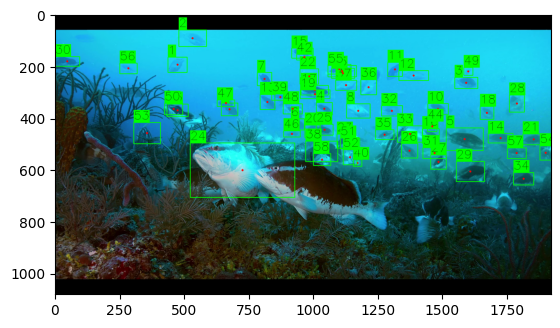

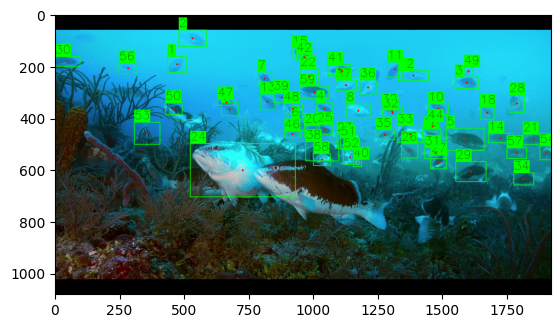

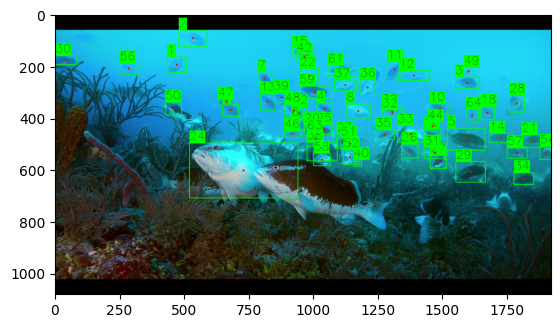

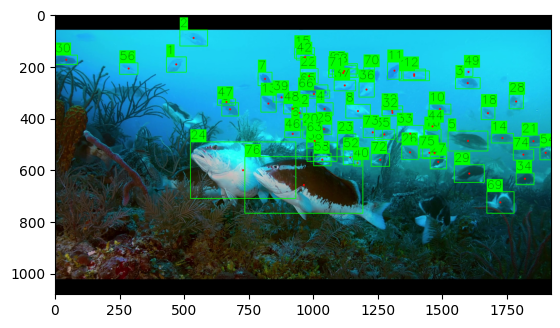

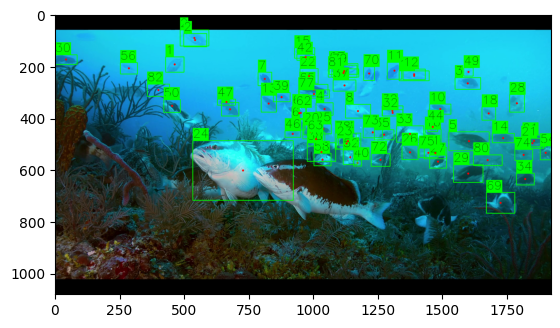

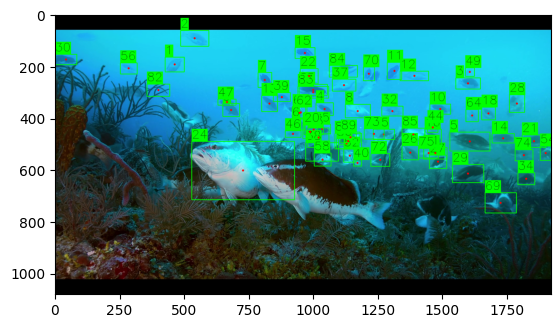

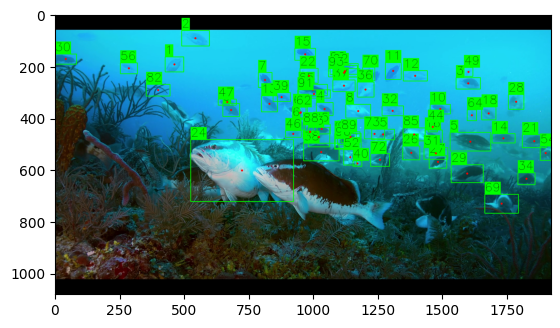

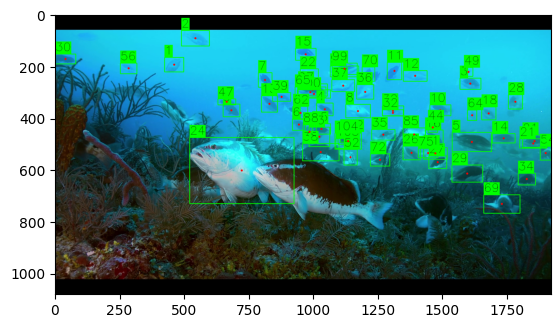

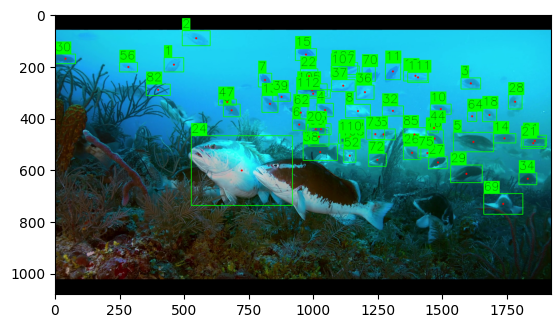

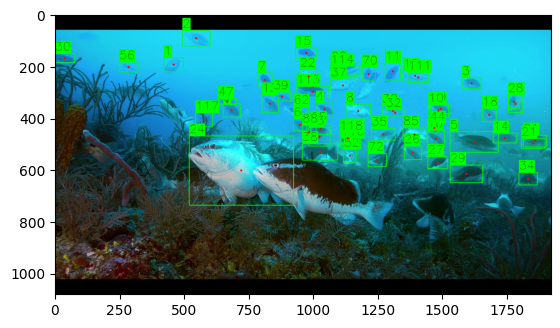

In [6]:
# Global variables
next_id = 1

# Display options
DISPLAY_CV2 = "cv2"
DISPLAY_PLT = "plt"
display_method = DISPLAY_PLT

DISPLAY_TEST = "test"
DISPLAY_FULL = "full"
display_length = DISPLAY_TEST

TEST_LENGTH = 10

# Update input size from frame
model.setInputParams(size=(height_nearest_32, width_nearest_32), scale=1/255)

# Select frame and apply detection
def process_frame(frame, display_method):
    """
    Run frame through model, mark up with boxes, and display output
    :param frame: img being processed, can be frame from a video
    :param display_method: DISPLAY_PLT (show each frame below code block) or DISPLAY_CV2 (display as popup window)
    """
    # Ensure global tracking objects are referenced
    global hit_detector
    global id_tracker
    global fish_detected
    global next_id

    # Adjust colours for Jupyter notebook
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Create copy of structures for updates
    frame_hit_tracker = np.copy(hit_detector)
    frame_id_tracker = copy.deepcopy(id_tracker)
    frame_object_tracker = copy.deepcopy(fish_detected)

    # Mark up frame with fish locations
    boxes = detect_fish(frame)
    for box in boxes:
        # Bounding box details
        (x, y, w, h) = box
        x2 = x + w
        y2 = y + h
        # Markup inputs
        border_colour = (0, 255, 0)
        border_width = 2
        centre = calculate_centrepoint(x, y, w, h)
        centre_radius = 1
        centre_colour = (255, 0, 0)
        centre_width = 5
        # Draw annotations
        cv2.circle(frame, centre, centre_radius, centre_colour, centre_width)
        cv2.rectangle(frame, (x, y), (x2, y2), border_colour, border_width)
        # Update tracking information
        id = -1
        sift_features = get_sift_features(frame, box, sift)
        search_radius = 10
        potential_matches = check_for_existing_object(centre[0], centre[1], search_radius, hit_detector, id_tracker)
        num_potential_matches = len(potential_matches)
        if num_potential_matches > 0:
            # At least one potential match found
            id = find_best_match(sift_features, potential_matches, fish_detected)
            # Update object info if potential matches returns a match based on features and if location has changed
            if id != -1 and object_moved(id, centre[0], centre[1], fish_detected):
                update_object_information(id, centre[0], centre[1], sift_features, frame_hit_tracker, frame_id_tracker, frame_object_tracker)
        if id == -1:
            # No match found, create new record
            id = next_id
            populate_object_trackers(frame_hit_tracker, frame_id_tracker, frame_object_tracker, (centre[0], centre[1], id, sift_features))
            next_id += 1
        # Add id to frame
        label = str(id)
        label_font = cv2.FONT_HERSHEY_SIMPLEX
        label_font_scale = 1.5
        label_font_thickness = 1
        label_bg_colour = border_colour
        label_text_colour = (0, 0, 0)
        text_size, _ = cv2.getTextSize(label, label_font, label_font_scale, label_font_thickness)
        text_width, text_height = text_size
        label_height = int(text_height * 1.5)
        # Add annotations to frame
        fill_argument = -1
        cv2.rectangle(frame, (x, y - label_height), (x + int(text_width), y), label_bg_colour, fill_argument)
        cv2.putText(frame, label, (x, y - int(label_height / 4)), label_font, label_font_scale, label_text_colour, label_font_thickness)

    # Update tracking objects
    hit_detector = frame_hit_tracker
    id_tracker = frame_id_tracker
    fish_detected = frame_object_tracker

    # Display image
    if (display_method == DISPLAY_CV2):
        cv2.imshow('custom window', frame)
        cv2.waitKey(1)
    else: # DISPLAY_PLT
        plt.imshow(frame)
        plt.show()

# Set up display conditions
if (display_method == DISPLAY_CV2):
    scaling_factor = 2
    cv2.namedWindow( 'custom window', cv2.WINDOW_KEEPRATIO )
    cv2.resizeWindow( 'custom window', (frame_size[1] // scaling_factor), (frame_size[0] // scaling_factor) )

# Check number of frames to display
if (display_length == DISPLAY_TEST):
    number_of_frames = TEST_LENGTH
else: # DISPLAY_FULL
    number_of_frames = int( footage.get( cv2.CAP_PROP_FRAME_COUNT ) )

# Skip frames to reach particular point in the footage 
num_skips = 0
skips = 0
while skips < num_skips:
    frame_exists, frame = footage.read()
    skips += 1

# Process number of frames
frame_count = 0
while frame_count < number_of_frames:
    if frame_exists:
        process_frame(frame, display_method)
        # Get next frame and update count
        frame_exists, frame = footage.read()
        frame_count += 1

footage.release()
cv2.destroyAllWindows()